In [1]:
import os  # for saving files
import numpy as np
from matplotlib import pyplot as plt

from muvi import geometry as geo

import vorpy as vp  # This can take ~20s for CUDA method to load


  Activating project at `~/Dropbox/code/vorpy`


Max number of thread: 640
Register usage: 96
Memory usage: (local = 280, shared = 0, constant = 0)


In [2]:
odir = 'vrtx_ring_fps'
if not os.path.exists(odir):
    os.makedirs(odir)

In [9]:
#############################################
# Generate a vortex (points, core radii, and
# circulation).
#############################################

# Vortex paramters
NUMSEGS = 100
RINGCENTER = (0, 0, 0)
RINGRADIUS = 5
CORERADIUS = 1

# Generate the vortex points
theta = np.linspace(0, 2 * np.pi, NUMSEGS)
vpx = RINGRADIUS * np.cos(theta) + RINGCENTER[0]
vpy = RINGRADIUS * np.sin(theta) + RINGCENTER[1]
vpz = np.zeros_like(vpx) + RINGCENTER[2]
vpps = np.concatenate([vpx[:, np.newaxis], vpy[:, np.newaxis], vpz[:, np.newaxis]], axis=1)
# To prevent numerical errors, explicitly set
# the last point to the the first.
vpps[-1] = vpps[0]

# Generate the core radii
vcrds = np.ones(NUMSEGS+1) * CORERADIUS

# Generate the circulation
vcirs = np.ones(NUMSEGS+1) * 1.0

In [10]:
# Boundary function takes a point and returns
# true if the point is inside the boundary
# The boundary functions are then used in the
# loop for deleting points where they are used
# to check if given point is inside the given
# boundary.

def far_field_boundary(x, y, z, center=(10, 10, 10), radius=6):
    xshf = x - center[0]
    yshf = y - center[1]
    zshf = z - center[2]
    return (xshf**2 + yshf**2) > radius**2 and center[2]-1 <= zshf <= center[2]+1

def ring_boundary(x, y, z, center=(10, 10, 10), radius1=4, radius2=6):
    xshf = x - center[0]
    yshf = y - center[1]
    zshf = z - center[2]
    
    def outer_ring(x, y):
        return (x**2 + y**2) <= radius2**2 

    def inner_ring(x, y):
        return (x**2 + y**2) >= radius1**2
    
    return outer_ring(xshf, yshf) and inner_ring(xshf, yshf) and center[2]-1 <= zshf <= center[2]+1

def ring_center_boundary(x, y, z, center=(10, 10, 10), radius=4):
    xshf = x - center[0]
    yshf = y - center[1]
    zshf = z - center[2]
    return (xshf**2 + yshf**2) < radius**2 and center[2]-1 <= zshf <= center[2]+1

# https://en.wikipedia.org/wiki/Torus
# Let R be the distance from the center of the tube
# to the center of the torus (i.e., the major radius),
# and r be the radius of the tube (i.e., the minor
# radius).
# R / r is known as the aspect ratio.
# - R > r: ring torus
# - R = r: horn torus
# - R < r: self intersecting spindle torus
# - R = 0: torus degenerates to a sphere
# When R >= r, the interior of the torus
# is given by
# (sqrt(x^2 + y^2) - R)^2 + z^2 < r^2
def torus_boundary(x, y, z, center=(10, 10, 10), major_radius=5, minor_radius=2):
    xshf = x - center[0]
    yshf = y - center[1]
    zshf = z - center[2]
    return (np.sqrt(xshf**2 + yshf**2) - major_radius)**2 + zshf**2 <= minor_radius**2

def torus_outside_boundray(x, y, z, center=(10, 10, 10), major_radius=5, minor_radius=2):
    return not torus_boundary(x, y, z, center, major_radius, minor_radius)


In [11]:
# What I want to be able to do:
# - [x] specify a density of points (points per area)
# - [x] specify a spacing between points (a sphere of empty space around each point)
# - [x] specify a region of interest (e.g. the region on and near the ring)

def euclidean_distance(pnt1, pnt2):
    return np.sqrt(np.sum((pnt1 - pnt2)**2))


def random_field_point_generator(numpts,
                                 spacing,
                                 xbounds,
                                 ybounds,
                                 zbounds,
                                 bounding_func=lambda x, y: True,
                                 **bounding_func_kwargs):
    '''
    numpts: number of points to generate. Final returned array may
        have fewer points if some are too close together.
    spacing: minimum radius of empty space around each point.
    xbounds: [xmin, xmax]
    ybounds: [ymin, ymax]
    zbounds: [zmin, zmax]
    bounding_func: function that takes x and y and returns True if
        the point is inside the boundary. If True, then every point
        is inside the boundary.
    '''
    # Generate random points
    rndxpnts = np.random.default_rng().uniform(*xbounds, numpts)
    rndypnts = np.random.default_rng().uniform(*ybounds, numpts)
    rndzpnts = np.random.default_rng().uniform(*zbounds, numpts)
    rndpnts = np.concatenate([rndxpnts[:, np.newaxis],
                              rndypnts[:, np.newaxis],
                              rndzpnts[:, np.newaxis]], axis=1)
    
    # print('rndpnts.shape:', rndpnts.shape)  # DEBUG
    
    # Keep picking points until one is inside the boundary
    # Rather than stopping the loop after iterating over
    # the whole array, we need to stop after some amount of
    # time or iterations (basically, assume the loop will not
    # terminate and stop it manually).
    indx1 = 0
    while(indx1 < len(rndpnts)):
        print('Progress:', f'{indx1/len(rndpnts):.2%}', end='\r')

        # First check if point is inside the boundary
        # if not, delete the point
        # We check both pnt1 and pnt2 against the boundary
        # which improves performance because we don't need
        # to check if pnt2 is too close if its not inside
        # the boundary.
        if not bounding_func(*rndpnts[indx1], **bounding_func_kwargs):
            rndpnts = np.delete(rndpnts, indx1, axis=0)
            continue

        # As we step through points in rndpnts, we 
        # checked each indx1 point against all others
        # so we can start checking indx2 points at
        # indx1. But we don't need to check indx1
        # against itself, so we start indx2 at indx1+1.
        indx2 = indx1 + 1 
        while(indx2 < len(rndpnts)):
            if not bounding_func(*rndpnts[indx2], **bounding_func_kwargs) or euclidean_distance(rndpnts[indx1], rndpnts[indx2]) < spacing:
                rndpnts = np.delete(rndpnts, indx2, axis=0)
                # Because we deleted a point, the shape of the
                # array has changed, so we don't want to increment
                # indx2.
            else:
                indx2 += 1

        indx1 += 1

    return rndpnts



In [12]:
# 100_000 points and spacing of 0.05 resunts in ~5900 points
# and takes 2:30 minutes to run.
fps_torus = random_field_point_generator(50_000, 1, [-10, 10], [-10, 10], [-10, 10], torus_boundary, center=(0, 0, 0))
print('fps_torus.shape:', fps_torus.shape)


fps_torus.shape: (255, 3)


In [21]:
fps_not_torus = random_field_point_generator(50_000, 15, [-50, 50], [-50, 50], [-50, 50], torus_outside_boundray)
print('fps_torus.shape:', fps_not_torus.shape)
# For 50_000 points and spacing of 5, it takes ~9:30 minutes to run
# and results in ~4300 points.

fps_torus.shape: (254, 3)


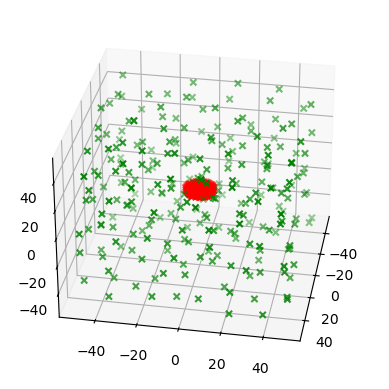

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(fps_torus[:, 0], fps_torus[:, 1], fps_torus[:, 2], marker='x', c='r', label='fps')
ax.scatter(fps_not_torus[:, 0], fps_not_torus[:, 1], fps_not_torus[:, 2], marker='x', c='g', label='fps_not')
ax.plot(vpps[:, 0], vpps[:, 1], vpps[:, 2], c='b', label='vortex')
ax.view_init(30, 10)
# plt.xlim(0, 20)
# plt.ylim(0, 20)
# ax.set_zlim(0, 20)
plt.show()

In [23]:
fps = np.concatenate([fps_torus, fps_not_torus], axis=0)
print('fps.shape:', fps.shape)

fps.shape: (509, 3)


In [24]:
vel_num = vp.bs_solve(fps, vpps, vcrds, vcirs, device='cuda')
print('vel_num.shape:', vel_num.shape)

vel_num.shape: (509, 3)


In [25]:
points = geo.Points(fps, vel=vel_num, metadata={})
points.save('vrtx_ring_fps/vortex_ring_2024_03_19_2.vtp')
points.save('vrtx_ring_fps/vortex_ring_2024_03_19_2.csv')

In [13]:
# fpsvls = np.concatenate([fps, vel_num], axis=1)
# print('fpsvls.shape:', fpsvls.shape)
# np.savetxt('vrtx_ring_fps/vel_num_2024_03_19.csv', fpsvls, delimiter=',', newline='\n')

fpsvls.shape: (322, 6)
